In [36]:
from pathlib import Path
import tflite
import tvm
from tvm import relay, transform
from tvm import te
import matplotlib.pyplot as plt
import imageio
import cv2
import numpy as np
import logging
logging.basicConfig(level=logging.DEBUG)

In [37]:
model_path = Path.cwd().parent / 'models' / 'face_landmark.tflite'
model_path.exists()

True

In [38]:
with open(model_path, 'rb') as f:
    tflite_model_buf = f.read()
    tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)
    input_tensor = "input_1"
    input_shape  = (5, 192, 192, 3)
    input_dtype  = "float32"
    
    mod, params = relay.frontend.from_tflite(
        tflite_model, 
        shape_dict = {input_tensor: input_shape},
        dtype_dict = {input_tensor: input_dtype}
    )
    
    desired_layouts = {'nn.conv2d': ['NCHW', 'default']}

    # Convert the layout to NCHW
    seq = tvm.transform.Sequential([relay.transform.RemoveUnusedFunctions(),
                                    relay.transform.ConvertLayout(desired_layouts)])
    
    target = "llvm"
    with transform.PassContext(opt_level=3):
        #mod = seq(mod)
        lib=relay.build(mod, target, params=params)

DEBUG:autotvm:Finish loading 35 records
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims

INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:com

INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest pr

INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for nn.prelu based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using depthwise_conv2d_NCHWc.x86 for nn.contrib_depthwise_conv2d_NCHWc based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INFO:compile_engine:Using conv2d_NCHWc.x86 for nn.contrib_conv2d_NCHWc based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority 

INFO:compile_engine:Using conv2d_NCHWc.x86 for nn.contrib_conv2d_NCHWc based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INFO:compile_engine:Using pool.cpu for nn.max_pool2d based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INFO:compile_engine:Using injective.cpu for nn.prelu based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using depthwise_conv2d_NCHWc.x86 for nn.contrib_depthwise_conv2d_NCHWc based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INF

In [39]:
video_path = Path.cwd().parent / "build" / "closeup_1.mp4"
video_path.exists()

True

In [40]:
reader = imageio.get_reader(str(video_path))

In [41]:
frames = []
for idx, frame in enumerate(reader):
    if idx == 5:
        break
    frame = cv2.resize(frame, (192, 192))
    frame = frame * 1.0 / 255.0
    frame = frame.astype(np.float32)
    frames.append(frame)
len(frames)

5

In [42]:
image_data = np.array(frames)
#image_batch = cv2.vconcat(image_data)
image_batch = cv2.dnn.blobFromImages(image_data)
image_batch = image_batch.reshape((5, 192, 192, 3))
image_batch.shape

(5, 192, 192, 3)

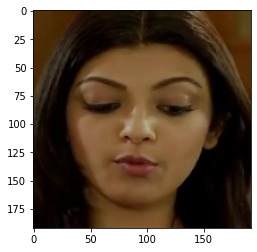

In [43]:
plt.imshow(image_data[4])
plt.show()

In [44]:
import tvm
from tvm import te
from tvm.contrib import graph_executor as runtime

# Create a runtime executor module
module = runtime.GraphModule(lib["default"](tvm.cpu()))

# Feed input data
module.set_input(input_tensor, tvm.nd.array(image_data))

# Run
module.run()



In [45]:
# Get output
landmarks = module.get_output(0).numpy()
scores = module.get_output(1).numpy()

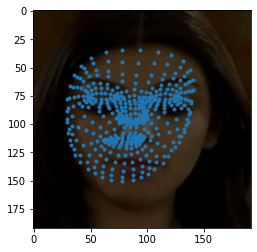

In [46]:
pos = np.squeeze(landmarks[0]).reshape((-1,3))
x = pos[:,0]
y = pos[:,1]
plt.imshow(image_data[0])
plt.plot(x, y,'.')
plt.show()